In [1]:
import sys
import os
from tqdm import tqdm
import numpy as np

sys.path.insert(0, os.path.abspath('../utils/')) #point this to the where util is relatively to your working directory

from util import *
import pandas as pd
import iso639
import matplotlib.pyplot as plt

data_dir = get_path_to_data_dir()

movie_details_join = pd.read_pickle(data_dir + 'pre-processed/movie_details_join.pkl')
movie_details_join.head(20)

# Directory for saving plots/figures
plots_dir = get_path_to_plot_dir()

# Is original language an important characteristic for success?

We would like to gain a sense of whether the original language of a movie is important to its success. To do so, we first examine the distribution of the original languages across the TMDB movie data set. 

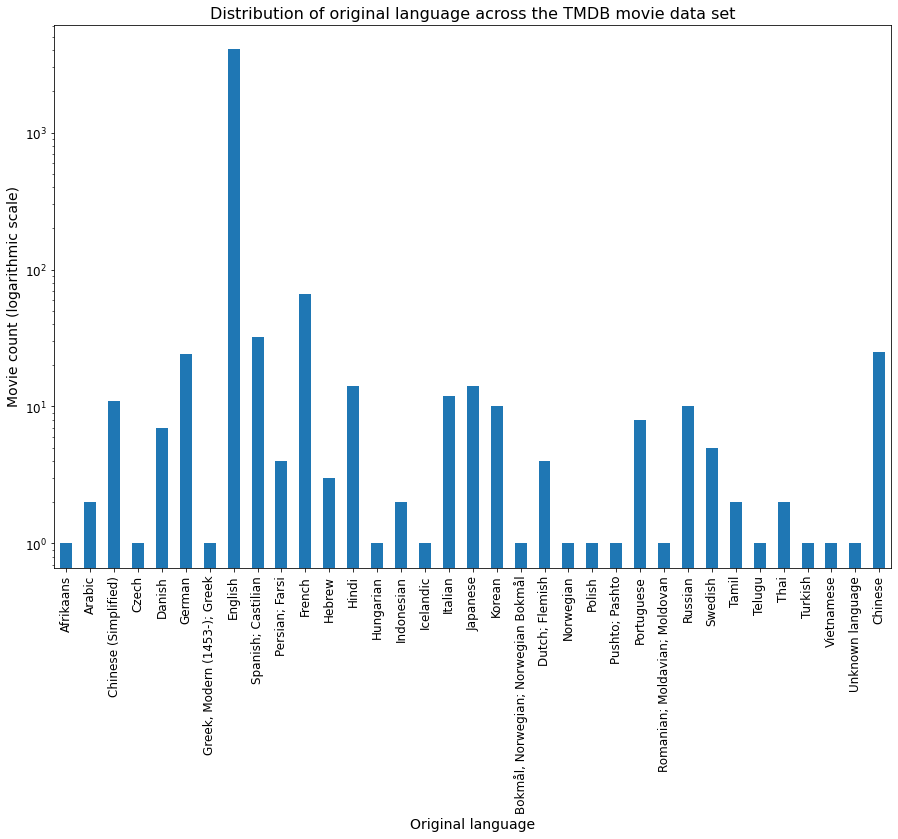

In [2]:
# Convert ISO-639 two-letter code to full name of language
def full_language(two_letter_code):
    
    if two_letter_code == 'xx':
        
        return 'Unknown language'
    
    elif two_letter_code == 'cn':
        
        return 'Chinese (Simplified)'

    else:
        
        return iso639.to_name(two_letter_code)

# Get number of movies for each original language
movie_details_language_aggregated = movie_details_join.groupby(['original_language'])['id'].count()

# Change index to full language name rather than ISO-639 two-letter code
movie_details_language_aggregated.index = movie_details_language_aggregated.index.map(full_language)  

# Plot barchart
movie_details_language_aggregated.plot.bar(figsize=(15,10), fontsize=12, logy=True)
plt.title('Distribution of original language across the TMDB movie data set', fontsize=16)
plt.rcParams.update({'figure.autolayout': True})
plt.xlabel('Original language', fontsize=14)
plt.ylabel('Movie count (logarithmic scale)', fontsize=14)
plt.savefig(plots_dir+'Barchart_original_language', bbox_inches = "tight")
plt.show()

Evidently, English is by far the most common (4055 movies) original language in the TMDB data set. 

# How is the popularity distributed?

According to TMDB, the popularity score for a given movie is based on:
(1) Number of votes for the day,
(2) number of views for the day,
(3) number of users who marked it as a "favourite" for the day,
(4) number of users who added it to their "watchlist" for the day,
(5) release date,
(6) number of total votes,
(7) previous days score.

Source: https://developers.themoviedb.org/3/getting-started/popularity. 

While the exact formula for the calculation of popularity is not revealed, we can nonetheless gain a sense of the distribution of popularity by plotting a histogram.

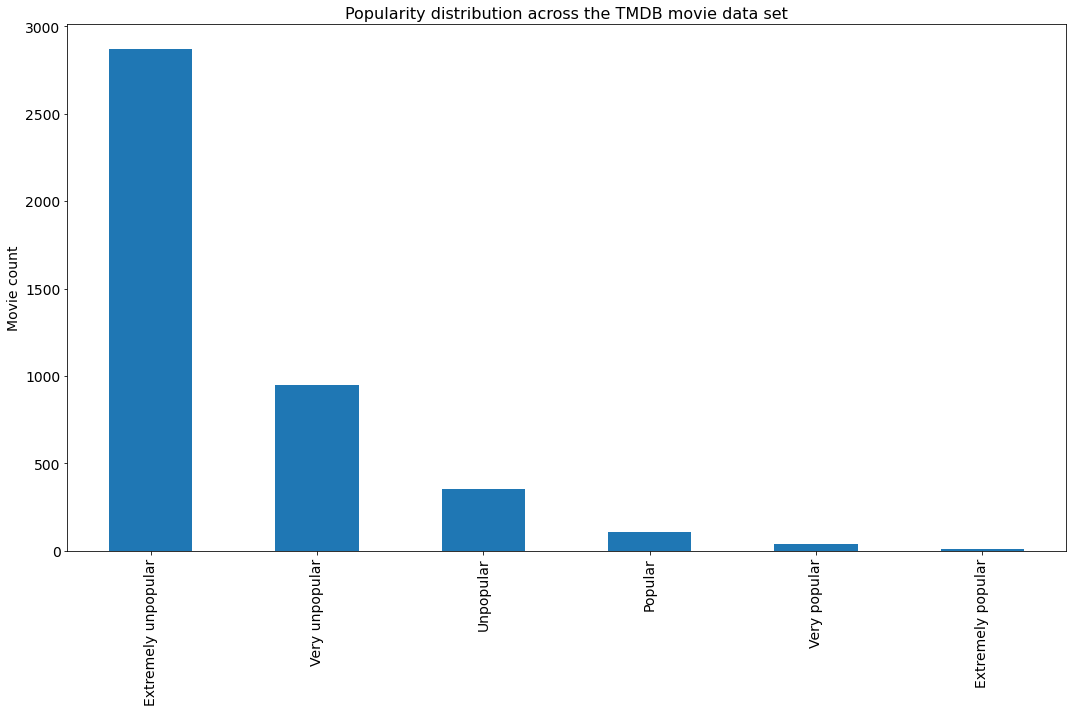

In [3]:
min_popularity = movie_details_join['popularity'].min()  # Returns 0.0003
max_popularity = movie_details_join['popularity'].max()  # Returns 116.70

# Based on values above, divide movies into categories (bins) based on popularity
bins = [0, 20, 40, 60, 80, 100, 120]
labels = ['Extremely unpopular', 'Very unpopular', 'Unpopular','Popular', 'Very popular', 'Extremely popular']

# Add column which identifies which popularity bin a movie belongs to
movie_details_join['binned'] = pd.cut(movie_details_join['popularity'], bins, labels=labels)

# Obtain number of movies in each popularity category
movie_details_popularity_binned = pd.cut(movie_details_join['popularity'], 
                                         bins=bins, labels=labels).value_counts()

# Plot a barchart with the results
fig = plt.figure(figsize=(15,10))
movie_details_popularity_binned.plot(kind='bar', fontsize=14)
plt.title(f'Popularity distribution across the TMDB movie data set', fontsize=16)
plt.ylabel('Movie count', fontsize=14)
plt.savefig(plots_dir + "Barchart_popularity.png")
plt.show()


# Do higher-rated or more populars movies earn more?

To explore which quantities are useful measures of success, it is useful to plot correlations with the revenue: from a business standpoint, it can be argued that the revenue is ultimately the most important metric of success and therefore should guide a production company on whether to invest in a particular movie. Quantities that offer alternatives measures of success include popularity and vote average. Importantly, the revenue should be normalized with respect to the budget - for 906 movies, the budget is reported as 0, presumably because the budget is unknown.

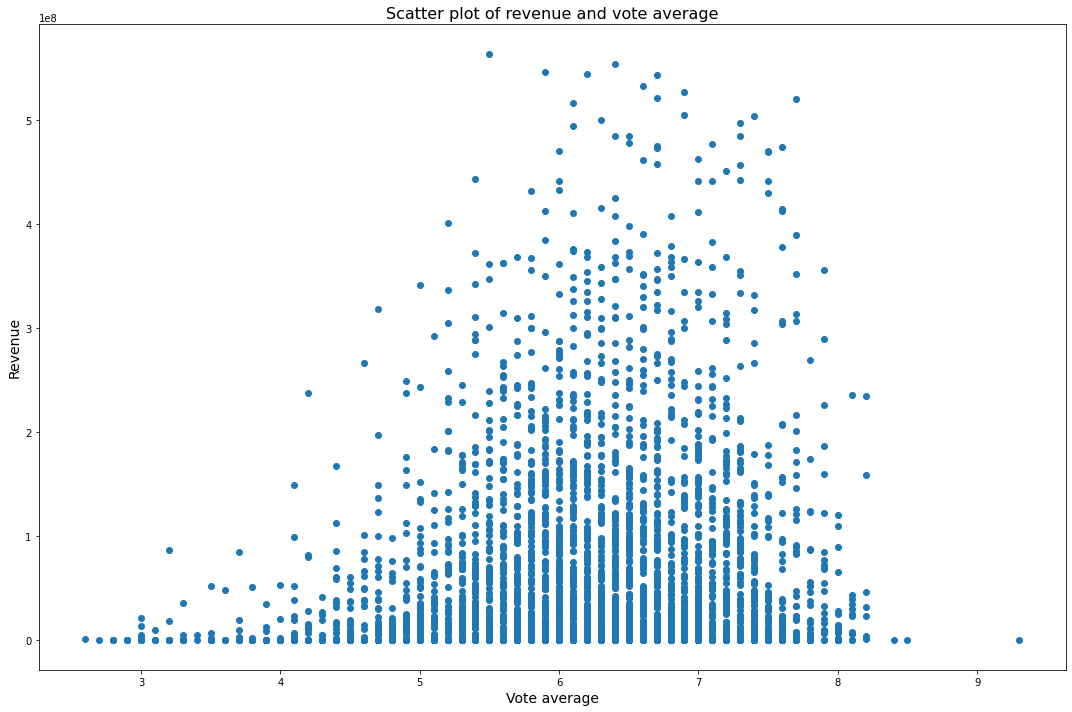

The correlation between revenue and vote average is: 0.146


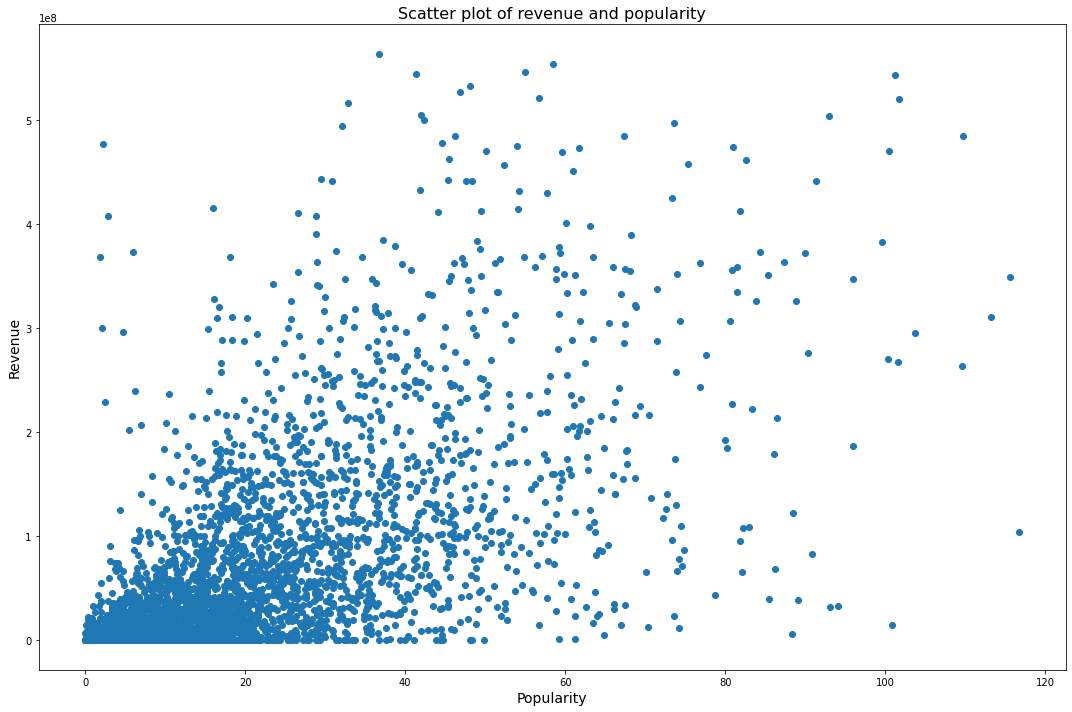

The correlation between revenue and popularity is: 0.659


In [4]:
# Correlation between revenue and a specified variable
def correlation_with_revenue(col_name, plot=True):
    
    # Normalize revenue with respect to budget
    movie_details_join['normalized_revenue'] = movie_details_join['revenue']#/movie_details_join['budget']
    
    if plot:
        fig = plt.figure(figsize=(15,10))
        plt.scatter(movie_details_join[col_name], 
                    movie_details_join['normalized_revenue']) 
        plt.ylabel('Revenue', fontsize=14)
        plt.xlabel(f'{col_name}'.replace("_", " ").capitalize(), fontsize=14)
        plt.title('Scatter plot of revenue and ' + f'{col_name}'.replace("_", " "), fontsize=16)
        plt.savefig(plots_dir + f'Scatterplot_revenue_'+f'{col_name}')
        plt.show()
    
    # Compute correlation coefficient between revenue and chosen column
    corr_coefficient = movie_details_join[['revenue', col_name]].corr(method='pearson').iloc[0, 1]
        
    return round(corr_coefficient, 3)

# Correlation between the revenue and vote average
print('The correlation between revenue and vote average is:', correlation_with_revenue('vote_average'))

# Correlation between the revenue and popularity
print('The correlation between revenue and popularity is:', correlation_with_revenue('popularity'))


The revenue and vote average are very uncorrelated, whereas revenue and popularity are moderately correlated. The latter seems plausible given that a higher popularity indicates that more people have seen the movie. Thus, while the vote average would not be a useful indicator of movie success, popularity could be a quantity that should be considered along with the revenue.